In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('/content/dataset_extreme.csv')
features = ['feature1', 'feature2', 'feature3']
X = data[features].values
y = data['VPN'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Random Forest hyperparameters to be tuned
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

random_forest = RandomForestClassifier()

# Scoring metrics for hyperparameter tuning
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring=scoring, refit='accuracy', cv=skf, verbose=3)
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Evaluation results for all hyperparameter combinations
cv_results = grid_search.cv_results_
for mean_acc, mean_f1, mean_prec, mean_rec, params in zip(cv_results['mean_test_accuracy'], cv_results['mean_test_f1'], cv_results['mean_test_precision'], cv_results['mean_test_recall'], cv_results['params']):
    print(f"Accuracy: {mean_acc}, F1-score: {mean_f1}, Precision: {mean_prec}, Recall: {mean_rec}, Params: {params}")

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
[CV 1/10] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; accuracy: (test=0.969) f1: (test=0.955) precision: (test=0.930) recall: (test=0.981) total time=   0.3s
[CV 2/10] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; accuracy: (test=0.994) f1: (test=0.991) precision: (test=1.000) recall: (test=0.981) total time=   0.1s
[CV 3/10] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=   0.3s
[CV 4/10] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; accuracy: (test=0.969) f1: (test=0.952) precision: (test=0.980) recall: (test=0.926) total time=   0.2s
[CV 5/10] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;

Average Accuracy: 0.9823, Average F1-score: 0.9841, Average Precision: 0.9847, Average Recall: 0.9837


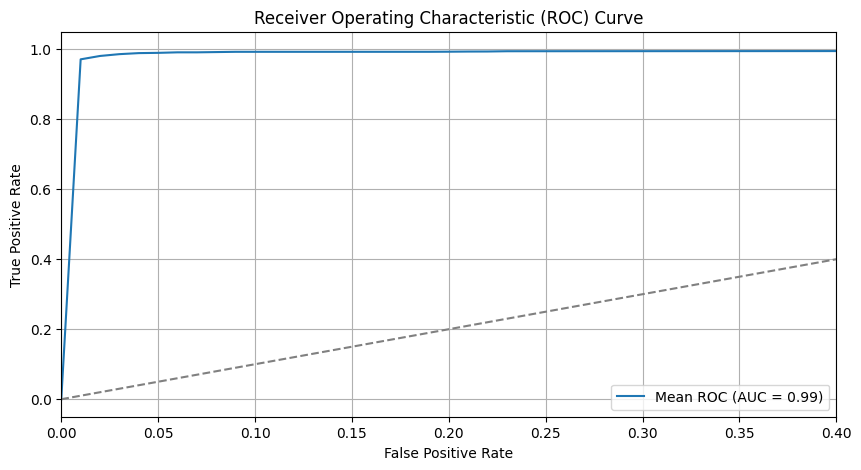

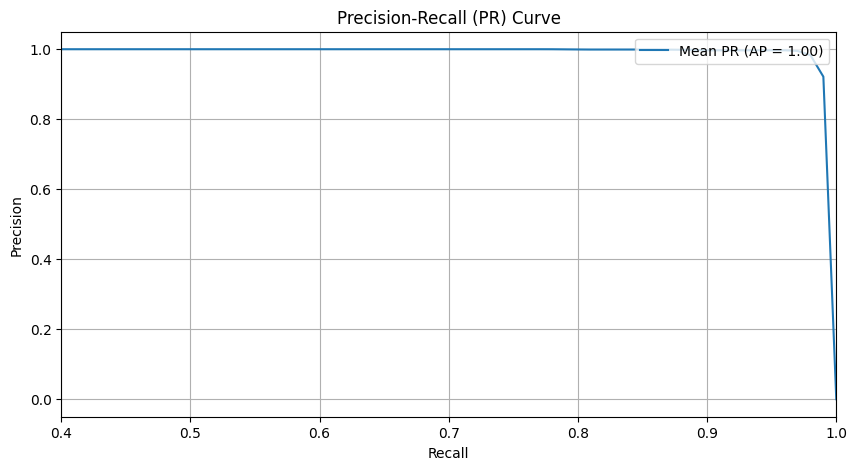

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
data = pd.read_csv('/content/dataset_all.csv')
features = ['feature1', 'feature2', 'feature3']
X = data[features].values
y = data['VPN'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Best parameters from the grid search
best_params = {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
# Initialize lists to store metrics
val_acc_cv = []
val_f1_cv = []
val_precision_cv = []
val_recall_cv = []
tpr_cv = []
precision_cv = []
roc_auc_cv = []
average_precision_cv = []
base_fpr = np.linspace(0, 1, 101)

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    random_forest = RandomForestClassifier(**best_params)
    random_forest.fit(X_train, y_train)

    y_pred_val = random_forest.predict(X_val)
    y_score_val = random_forest.predict_proba(X_val)[:, 1]

    val_acc_cv.append(accuracy_score(y_val, y_pred_val))
    val_f1_cv.append(f1_score(y_val, y_pred_val))
    val_precision_cv.append(precision_score(y_val, y_pred_val))
    val_recall_cv.append(recall_score(y_val, y_pred_val))

    fpr, tpr, _ = roc_curve(y_val, y_score_val)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_val, y_score_val)
    average_precision = average_precision_score(y_val, y_score_val)

    tpr_cv.append(np.interp(base_fpr, fpr, tpr))
    tpr_cv[-1][0] = 0.0
    precision_cv.append(np.interp(base_fpr, recall[::-1], precision[::-1]))
    precision_cv[-1][0] = 1.0

    roc_auc_cv.append(roc_auc)
    average_precision_cv.append(average_precision)

# Print average validation accuracy, F1-score, Precision, and Recall over all folds
print(f"Average Accuracy: {np.mean(val_acc_cv):.4f}, Average F1-score: {np.mean(val_f1_cv):.4f}, Average Precision: {np.mean(val_precision_cv):.4f}, Average Recall: {np.mean(val_recall_cv):.4f}")
tpr_mean = np.mean(tpr_cv, axis=0)
tpr_mean[-1] = 1.0
roc_auc_mean = np.mean(roc_auc_cv)

precision_mean = np.mean(precision_cv, axis=0)
precision_mean[-1] = 0.0
average_precision_mean = np.mean(average_precision_cv)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(base_fpr, tpr_mean, label=f'Mean ROC (AUC = {roc_auc_mean:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.xlim(0, 0.4)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 5))
plt.plot(base_fpr, precision_mean, label=f'Mean PR (AP = {average_precision_mean:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='upper right')
plt.grid()
plt.xlim(0.4, 1)
plt.show()
